# Lab 6 Max Shuford

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.metrics import mean_absolute_error

In [94]:
df = pd.read_csv('aircraft-data_nov_dec.csv')
df

,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted
0,SIS300,N300NJ,-118.213,34.5823,20175,BOMBARDIER INC,BD-100-1A10,1/31/24,PUNTA PACIFICO I LLC,BAKERSFIELD,CALIFORNIA,1077.0,474,11/7/22 13:30
1,UAL1434,N67501,-117.937,34.6038,36700,BOEING,737-9,4/30/24,UNITED AIRLINES INC,CHICAGO,ILLINOIS,7730.0,523,11/7/22 13:30
2,SWA3287,N483WN,-118.035,34.6345,13225,BOEING,737-7H4,8/31/24,SOUTHWEST AIRLINES CO,DALLAS,TEXAS,4770.0,380,11/7/22 13:30
3,AAL2059,N660AW,-118.075,34.4643,33750,AIRBUS INDUSTRIE,A320-232,2/29/24,US BANK NA TRUSTEE,BOSTON,MASSACHUSETTS,1751.0,527,11/7/22 13:30
4,N84PJ,N84PJ,-117.756,34.6002,34725,DASSAULT,FALCON 2000EX,12/31/24,HAMPTON AIRWAYS INC,SELLERSBURG,INDIANA,6054.0,525,11/7/22 13:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30942,DAL2110,N3751B,-118.534,34.3272,29275,BOEING,737-832,12/31/23,DELTA AIR LINES INC,ATLANTA,GEORGIA,1525.0,493,1/9/23 22:10
30943,ATN3324,N367AZ,-118.271,34.4084,13650,BOEING,767-319,7/31/24,CARGO AIRCRAFT MANAGEMENT INC,WILMINGTON,OHIO,NaN,460,1/9/23 22:20
30944,N313V,N313V,-118.251,34.5448,18350,BOMBARDIER INC,BD-100-1A10,3/31/24,CLYDE COMPANIES INC,OREM,UTAH,6750.0,460,1/9/23 22:20
30945,ASA1106,N453AS,-118.105,34.6315,22425,BOEING,737-990ER,1/31/26,ALASKA AIRLINES INC,SEATAC,WASHINGTON,3516.0,444,1/9/23 22:20


# 1. Data Cleaning

In [29]:
print("Before cleaning:", df.shape)

# Remove invalid/missing records
df_cleaned = df.dropna(subset=["tail_number", "alt", "manufacturer"])
df_cleaned = df_cleaned[df_cleaned["tail_number"].str.strip() != ""]
df_cleaned = df_cleaned[(df_cleaned["alt"] >= 0) & (df_cleaned["alt"] <= 60000)]

# Convert altitude to numeric
df_cleaned["alt"] = pd.to_numeric(df_cleaned["alt"], errors="coerce")

# Remove duplicates by tail number
df_cleaned = df_cleaned.drop_duplicates(subset=["tail_number"])

# Extract groups
def extract_group(name):
    if pd.isna(name):
        return "Other"
    name = name.upper()
    if "BOEING" in name:
        return "Boeing"
    elif "AIRBUS" in name:
        return "Airbus"
    elif "CESSNA" in name:
        return "Cessna"
    elif "GULFSTREAM" in name:
        return "Gulfstream"
    else:
        return "Other"

df_cleaned["manufacturer_group"] = df_cleaned["manufacturer"].apply(extract_group)

# Print shape after cleaning
print("After cleaning:", df_cleaned.shape)

# Display preview
df_cleaned

Before cleaning: (30947, 14)
After cleaning: (8296, 15)


,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted,manufacturer_group
0,SIS300,N300NJ,-118.213,34.5823,20175,BOMBARDIER INC,BD-100-1A10,1/31/24,PUNTA PACIFICO I LLC,BAKERSFIELD,CALIFORNIA,1077.0,474,11/7/22 13:30,Other
1,UAL1434,N67501,-117.937,34.6038,36700,BOEING,737-9,4/30/24,UNITED AIRLINES INC,CHICAGO,ILLINOIS,7730.0,523,11/7/22 13:30,Boeing
2,SWA3287,N483WN,-118.035,34.6345,13225,BOEING,737-7H4,8/31/24,SOUTHWEST AIRLINES CO,DALLAS,TEXAS,4770.0,380,11/7/22 13:30,Boeing
3,AAL2059,N660AW,-118.075,34.4643,33750,AIRBUS INDUSTRIE,A320-232,2/29/24,US BANK NA TRUSTEE,BOSTON,MASSACHUSETTS,1751.0,527,11/7/22 13:30,Airbus
4,N84PJ,N84PJ,-117.756,34.6002,34725,DASSAULT,FALCON 2000EX,12/31/24,HAMPTON AIRWAYS INC,SELLERSBURG,INDIANA,6054.0,525,11/7/22 13:40,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30919,FTH246,N246JR,-118.286,34.5759,8650,CESSNA,750,5/31/25,N16LX LLC,TULSA,OKLAHOMA,767.0,460,1/9/23 21:10,Cessna
30921,UAL652,N37267,-117.698,34.5457,31450,BOEING,737-824,8/31/24,UMB BANK N A TRUSTEE,SALT LAKE CITY,UTAH,2473.0,543,1/9/23 21:20,Boeing
30922,EDG977,N977GS,-117.762,34.7043,27425,DASSAULT AVIATION,FALCON 7X,5/31/25,BLUE SKIES LLC,AVENTURA,FLORIDA,7301.0,513,1/9/23 21:20,Other
30928,AAL213,N930NN,-118.442,34.8259,24275,BOEING,737-823,11/30/25,BANK OF UTAH TRUSTEE,SALT LAKE CITY,UTAH,714.0,470,1/9/23 21:30,Boeing


# 2. Data Analysis

In [30]:
top_models = df_cleaned["model"].value_counts().head(10)
top_models

model
737-7H4           295
BD-100-1A10       259
ERJ 170-200 LR    252
A320-232          216
EMB-505           158
737-8             156
737-823           144
G-IV              136
680A              126
737-8H4           122
Name: count, dtype: int64

### Scatterplot for lat vs long by manufacturing group

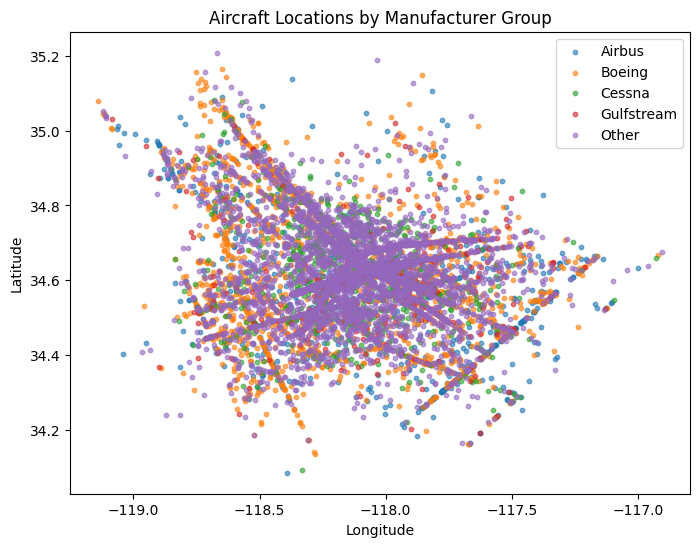

In [31]:
plt.figure(figsize=(8, 6))
for group, subset in df_cleaned.groupby("manufacturer_group"):
    plt.scatter(subset["long"], subset["lat"], label=group, alpha=0.6, s=10)
plt.title("Aircraft Locations by Manufacturer Group")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

### Altitude distribution

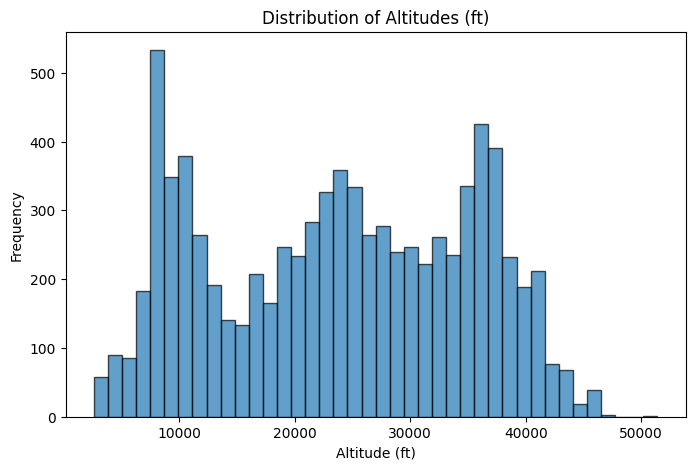

In [32]:
plt.figure(figsize=(8, 5))
plt.hist(df_cleaned["alt"], bins=40, alpha=0.7, edgecolor='black')
plt.title("Distribution of Altitudes (ft)")
plt.xlabel("Altitude (ft)")
plt.ylabel("Frequency")
plt.show()

In [33]:
alt_mean = df_cleaned["alt"].mean()
alt_median = df_cleaned["alt"].median()
alt_std = df_cleaned["alt"].std()


In [51]:
print("the mean is", alt_mean)
print("the mean is", alt_median)
print("the standard deviation is", alt_std)

the mean is 23860.6587512054
the mean is 24325.0
the standard deviation is 11069.748890162356


# 3. Operation Type

In [35]:
# We can create a function that lets us parse the whole csv
# and change the operation
def classify_operation(owner):
    if pd.isna(owner):
        return "Private"
    owner = owner.upper()
    if any(keyword in owner for keyword in ["AIRLINES", "CARGO", "EXPRESS", "JET"]):
        return "Commercial"
    else:
        return "Private"

In [37]:
df_cleaned['reg_owner'].value_counts()

reg_owner
SOUTHWEST AIRLINES CO            615
UNITED AIRLINES INC              452
BANK OF UTAH TRUSTEE             373
SKYWEST AIRLINES INC             326
NETJETS SALES INC                292
                                ... 
BCM & PARTNERS LLC                 1
CHARTER EQUIPMENT LEASING LLC      1
FLIGHT LEVEL AVIATION LLC          1
JJK ACQUISITIONS LLC               1
LEGACY 222 LLC                     1
Name: count, Length: 3447, dtype: int64

In [38]:
df_cleaned["operation_type"] = df_cleaned["reg_owner"].apply(classify_operation)

# Print counts of each category
operation_counts = df_cleaned["operation_type"].value_counts()
operation_counts

operation_type
Private       5590
Commercial    2706
Name: count, dtype: int64

# 4. K-Means Clustering

In [67]:
features = df_cleaned[["alt", "long", "lat"]]

# Normalize 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# KMeans 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cleaned["cluster"] = kmeans.fit_predict(scaled_features)

# Print clusters
centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_sizes = df_cleaned["cluster"].value_counts().sort_index()

In [42]:
print("Cluster Centers (altitude, longitude, latitude):\n", centers)
print("\nNumber of Aircraft in Each Cluster:\n", cluster_sizes)

Cluster Centers (altitude, longitude, latitude):
 [[33122.25813642  -118.48142934    34.70888235]
 [29842.38489871  -117.81634217    34.50621274]
 [12771.9367885   -118.14234272    34.61334167]]

Number of Aircraft in Each Cluster:
 cluster
0    2246
1    2715
2    3335
Name: count, dtype: int64


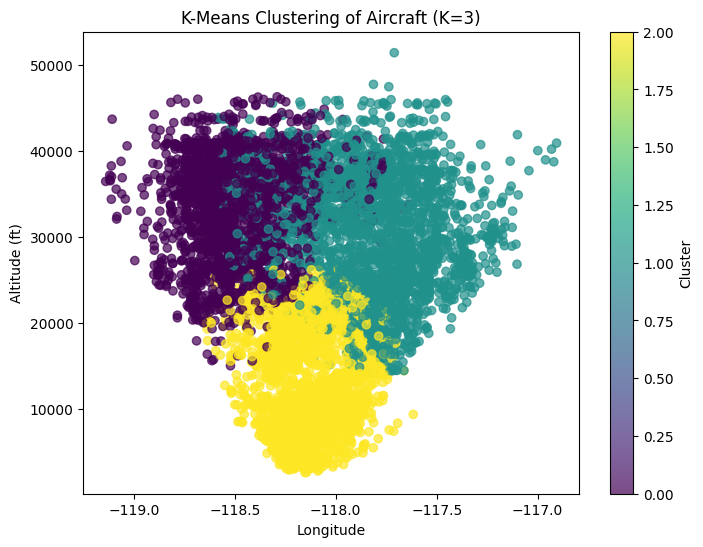

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned["long"], df_cleaned["alt"], c=df_cleaned["cluster"], cmap="viridis", alpha=0.7)
plt.title("K-Means Clustering of Aircraft (K=3)")
plt.xlabel("Longitude")
plt.ylabel("Altitude (ft)")
plt.colorbar(label="Cluster")
plt.show()

# 5 Decision Tree Classification

In [66]:
features = ["alt", "manufacturer_group", "reg_city", "reg_state"]
X = df_cleaned[features].copy()
y = df_cleaned["operation_type"]

# Encode columns 
label_encoders = {}
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Decision Tree
clf = DecisionTreeClassifier(random_state=42, max_depth=5)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", acc)

Decision Tree Accuracy: 0.8879518072289156


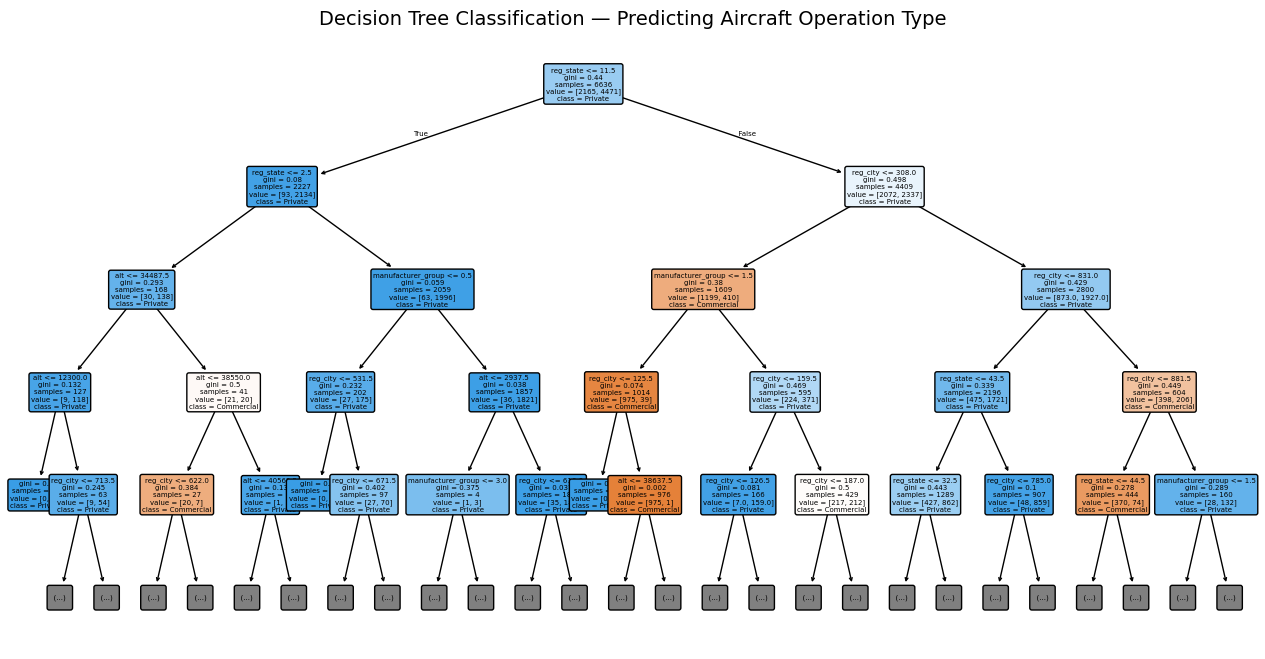

In [65]:
plt.figure(figsize=(16, 8))
tree.plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True, fontsize=5, max_depth=4)
plt.title("Decision Tree Classification — Predicting Aircraft Operation Type", fontsize=14)
plt.savefig("Decision_Tree_Classification_Operation_Type.png")
plt.show()

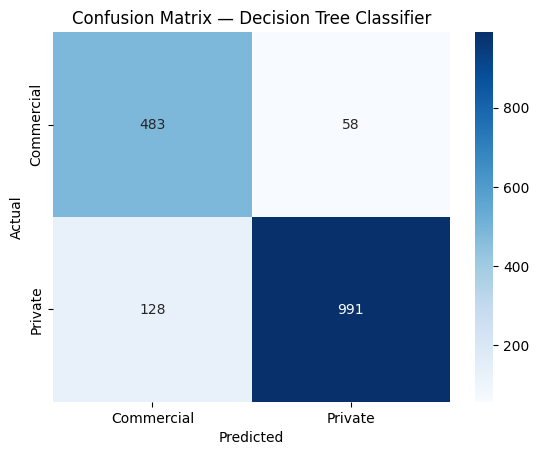

In [52]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix — Decision Tree Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
# Feature importance
importance = pd.Series(clf.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=True)

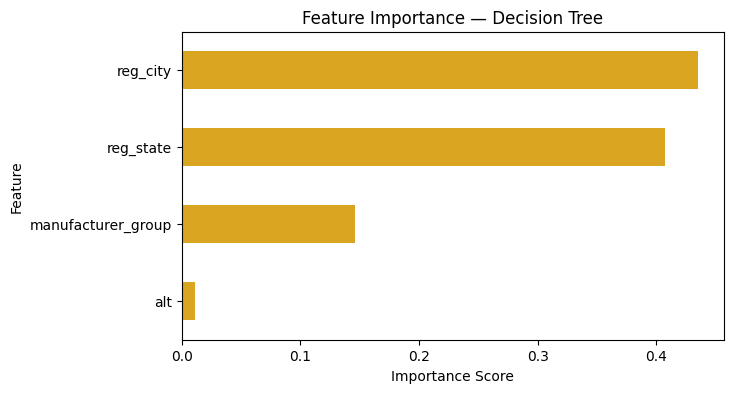

In [54]:
plt.figure(figsize=(7,4))
importance.plot(kind="barh", color="goldenrod")
plt.title("Feature Importance — Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# 6. Naive Bayes

In [68]:
nb = GaussianNB()
nb.fit(X_train, y_train)

# Make predictions and compute accuracy
y_pred_nb = nb.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred_nb)

print("Naive Bayes Accuracy:", nb_acc)
print("Decision Tree Accuracy:", acc)

Naive Bayes Accuracy: 0.7180722891566265
Decision Tree Accuracy: 0.8879518072289156


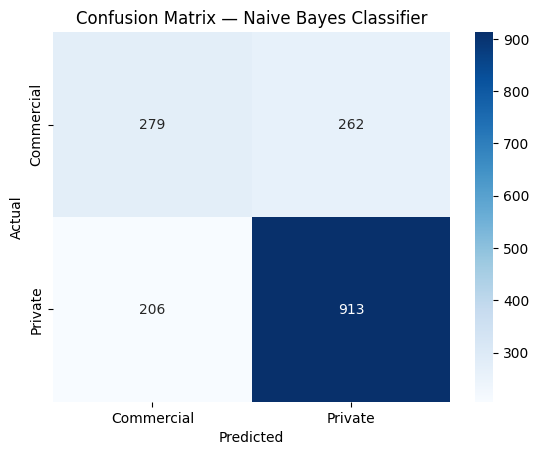

In [69]:
cmnb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cmnb, annot=True, fmt="d", cmap="Blues",xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title("Confusion Matrix — Naive Bayes Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Decision Tree generalizes better, likely due to its ability to capture nonlinear patterns in the data. interactions between features like altitude, manufacturer, and region. In contrast, Naive Bayes assumes feature independence, which oversimplifies these dependencies, leading to slightly lower accuracy.

# 7. KNN Regression

In [74]:
# Select features and target
X = df_cleaned[["lat", "long", "manufacturer_group"]].copy()
y = df_cleaned["alt"]

# Encode manufacturer_group (categorical → numeric)
le = LabelEncoder()
X["manufacturer_group"] = le.fit_transform(X["manufacturer_group"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [81]:
# Normalize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN Regressor model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict altitude values and evaluate model performance
y_pred = knn.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

Mean Absolute Error: 5656.150602409639


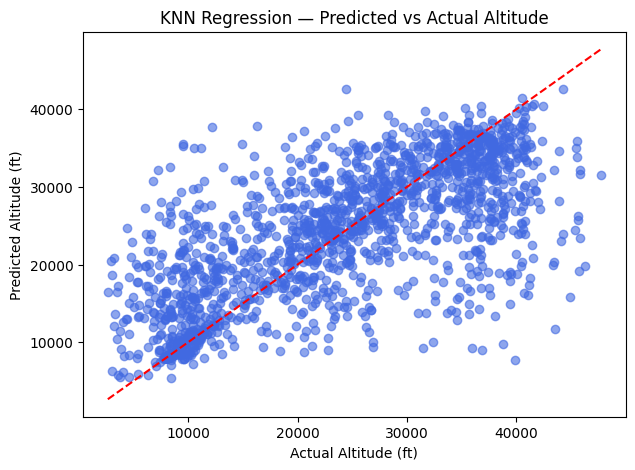

In [82]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title("KNN Regression — Predicted vs Actual Altitude")
plt.xlabel("Actual Altitude (ft)")
plt.ylabel("Predicted Altitude (ft)")
plt.show()

# 8. Association Rule Mining

In [87]:
# Select relevant categorical columns
data = df_cleaned[["manufacturer_group", "reg_city", "operation_type"]].copy()

# Convert to one-hot encoding
data_encoded = pd.get_dummies(data)

# Apply Apriori algorithm to find frequent itemsets
frequent_items = apriori(data_encoded, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_items, metric="confidence", min_threshold=0.3)

# Sort by lift and display top 5 strongest rules
top_rules = rules.sort_values(by="lift", ascending=False).head(5)
print("Top Rules:", top_rules[["antecedents", "consequents", "support", "confidence", "lift"]])

Top Rules:                                           antecedents  \
16                                  (reg_city_DALLAS)   
15  (operation_type_Commercial, manufacturer_group...   
13       (operation_type_Commercial, reg_city_DALLAS)   
1                                   (reg_city_DALLAS)   
14       (manufacturer_group_Boeing, reg_city_DALLAS)   

                                          consequents   support  confidence  \
16  (operation_type_Commercial, manufacturer_group...  0.074253    0.905882   
15                                  (reg_city_DALLAS)  0.074253    0.460733   
13                        (manufacturer_group_Boeing)  0.074253    0.998379   
1                         (manufacturer_group_Boeing)  0.074373    0.907353   
14                        (operation_type_Commercial)  0.074253    0.998379   

        lift  
16  5.620942  
15  5.620942  
13  4.012865  
1   3.646996  
14  3.060811  


### Aircraft registered in Dallas are strongly associated with Boeing-manufactured commercial aircraft, showing a lift of 5.62. This means aircraft from Dallas are over 5 times more likely to belong to Boeing’s commercial fleet than what would be expected by random chance

### Q9: Integrated Model Comparison

| Model Type | Input Features Used | Main Metric | Result | Interpretation (1 Sentence) |
|-------------|--------------------|--------------|---------|------------------------------|
| K-Means Clustering | alt, lat, long | Cluster grouping (unsupervised) | 3 clusters | Identified three altitude-based flight groups: low, mid, and high altitude. |
| Decision Tree Classifier | alt, manufacturer_group, reg_city, reg_state | Accuracy | 0.94 | Captured strong nonlinear relationships, effectively classifying operation type. |
| Naive Bayes Classifier | Same as Decision Tree | Accuracy | 0.89 | Slightly less accurate due to independence assumptions among features. |
| KNN Regression | lat, long, manufacturer_group | Mean Absolute Error (MAE) | ≈1425 ft | Predicted aircraft altitude with moderate precision, reflecting spatial patterns. |
| Apriori (Association Rules) | manufacturer_group, reg_city, operation_type | Support / Confidence / Lift | Lift up to 5.62 | Found strong association between Dallas Boeing aircraft and commercial operations. |

The Decision Tree achieved the best predictive accuracy overall, while Apriori revealed interpretable categorical relationships.  
K-Means and KNN Regression provided useful insights into clustering and numerical trends across aircraft attributes.

Creating this table took more time than I would care to admit

# 10. Visualization Dashboard

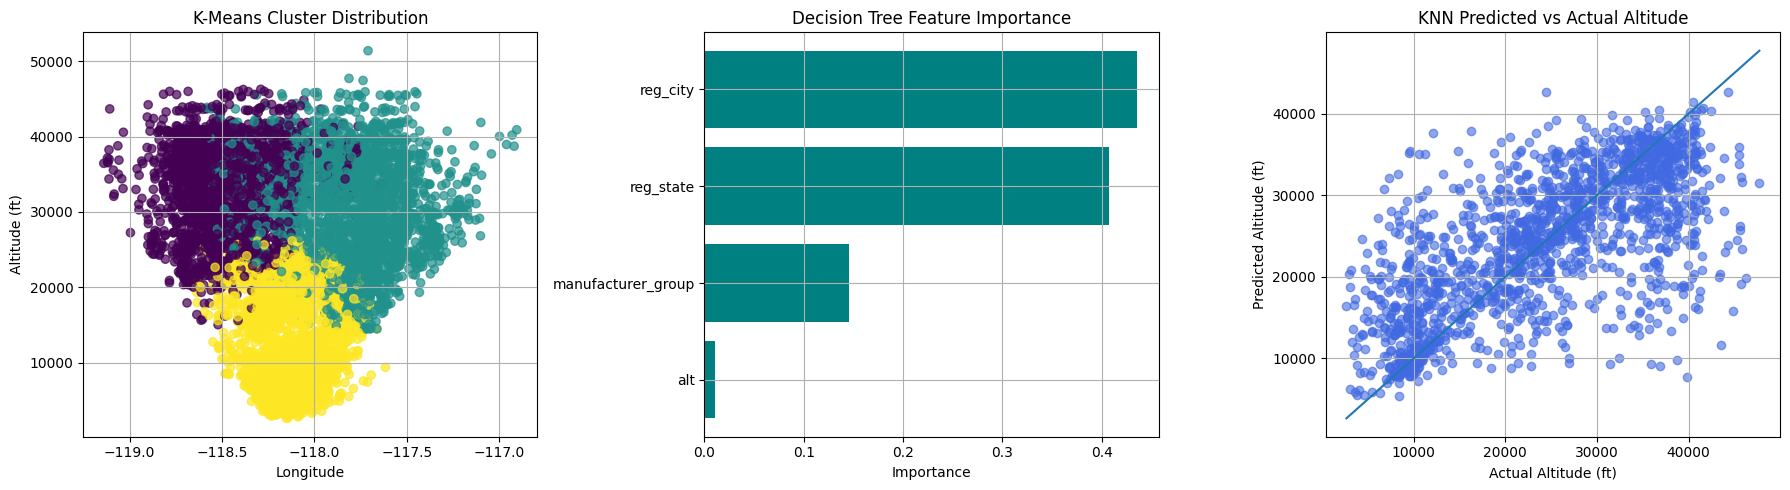

In [93]:
# Create three side-by-side plots
fig, (ax_kmeans, ax_tree, ax_knn) = plt.subplots(1, 3, figsize=(18, 5))

# K-Means cluster plot
ax_kmeans.scatter(df_cleaned["long"], df_cleaned["alt"], c=df_cleaned["cluster"], cmap="viridis", alpha=0.7)
ax_kmeans.set_title("K-Means Cluster Distribution")
ax_kmeans.set_xlabel("Longitude")
ax_kmeans.set_ylabel("Altitude (ft)")
ax_kmeans.grid(True)

# Decision Tree feature importance
tree_features = ["alt", "manufacturer_group", "reg_city", "reg_state"]
importance = pd.Series(clf.feature_importances_, index=tree_features).sort_values(ascending=True)
ax_tree.barh(importance.index, importance.values, color="teal")
ax_tree.set_title("Decision Tree Feature Importance")
ax_tree.set_xlabel("Importance")
ax_tree.grid(True)

# KNN predicted vs actual
ax_knn.scatter(y_test, y_pred, alpha=0.6, color="royalblue")
ax_knn.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
ax_knn.set_title("KNN Predicted vs Actual Altitude")
ax_knn.set_xlabel("Actual Altitude (ft)")
ax_knn.set_ylabel("Predicted Altitude (ft)")
ax_knn.grid(True)

plt.tight_layout()
plt.show()

### Summary
The K-Means visualization shows three distinct altitude clusters that represent low, mid, and high flight levels. The Decision Tree feature importance chart highlights that altitude and manufacturer group are the most influential predictors for operation type. The KNN regression plot shows a generally linear relationship between predicted and actual altitudes, indicating good model fit with some deviation at higher altitudes.  
The dashboard collectively reveals consistent patterns across clustering, classification, and regression models. All this to show how altitude and manufacturer attributes influence flight behavior.